In [1]:
from utils.vector import Vec4 
from utils.alphas import AlphaS
from utils.particle import Particle as pa
#from utils.particle import check_event
from utils.shower import Shower
from utils.analysis import Analysis
from utils.histogram import Histo1D
from operator import itemgetter
from utils.yoda import plot_jet_histograms

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

seed = 7654
rng = np.random.default_rng(seed)

# defining all the constants

pi = np.pi

qed_coupling = 1/129

qcd_coupling = 0.118

zboson_mass = 91.2

zboson_decaywidth = 2.5

weinberg_angle = 0.223

electron_charge = -1

upquark_charge = 2/3

downquark_charge = -1/3

upquark_isospin = 1/2

downquark_isospin = -1/2

number_of_quark_flavours = 5

number_of_qcd_colours = 3

conversion_factor = 3.89379656*10**8

kappa = 1/(4*weinberg_angle*(1-weinberg_angle))

electron_vectorcoupling = downquark_isospin - 2* electron_charge*weinberg_angle

upquark_vectorcoupling = upquark_isospin - 2* upquark_charge*weinberg_angle

downquark_vectorcoupling= downquark_isospin - 2* downquark_charge*weinberg_angle

In [2]:
def chi_1(s): 

    return kappa* (s*(s- zboson_mass**2))/((s- zboson_mass**2)**2 + zboson_decaywidth**2 * zboson_mass**2)

def chi_2(s):

    return kappa**2 * (s**2)/((s- zboson_mass**2)**2 + zboson_decaywidth**2 * zboson_mass**2)
    
#defining the matrix element e^+ e^- --> qq

def matrix_element(s,cos_theta,quark_flavour):

    if (quark_flavour == 2 or quark_flavour ==5): 
        return (4*pi*qed_coupling)**2 * number_of_qcd_colours* ((1+ cos_theta**2)*(electron_charge**2*upquark_charge**2 + 2* electron_charge * upquark_charge* electron_vectorcoupling * upquark_vectorcoupling * chi_1(s) + (downquark_isospin**2+ electron_vectorcoupling**2)*(upquark_isospin**2 + upquark_vectorcoupling**2)*chi_2(s))+ cos_theta* (4* electron_charge*upquark_charge*downquark_isospin*upquark_isospin*chi_1(s)+ 8* downquark_isospin*electron_vectorcoupling* upquark_isospin* upquark_vectorcoupling*chi_2(s)))
    
    else:  
        return (4*pi*qed_coupling)**2 * number_of_qcd_colours* ((1+ cos_theta**2)*(electron_charge**2*downquark_charge**2 + 2* electron_charge * downquark_charge* electron_vectorcoupling * downquark_vectorcoupling * chi_1(s) + (downquark_isospin**2+ electron_vectorcoupling**2)*(downquark_isospin**2 + downquark_vectorcoupling**2)*chi_2(s))+ cos_theta* (4* electron_charge*downquark_charge*downquark_isospin*downquark_isospin*chi_1(s)+ 8* downquark_isospin*electron_vectorcoupling* downquark_isospin* downquark_vectorcoupling*chi_2(s)))

def differential_cross_section(s,cos_theta,quark_flavour):
    number = quark_flavour
    return conversion_factor * 1/(8*pi) *1/(4*pi) * 1/(2*s) *matrix_element(s,cos_theta,number)

In [3]:
#1.2b
#monte carlo integrator with generating the particles four-momenta
def mc_integrator(function, low_limits, up_limits, number_of_samples):
    
    dimension = len(low_limits)
    
    integration_volume = np.prod(up_limits- low_limits)
    
    samples = rng.uniform(low_limits, up_limits, size=(number_of_samples, dimension))
    
    random_flavours = rng.integers(1,number_of_quark_flavours+1,size=(number_of_samples))
    
    function_values = [function(zboson_mass**2,samples[:,0][i],random_flavours[i]) for i in range(number_of_samples)]
        
    p_eplus = [Vec4(zboson_mass/2,0,0,zboson_mass/2) for _ in range(len(samples[:,0]))]
    
    p_eminus = [Vec4(zboson_mass/2,0,0,-zboson_mass/2) for _ in range(len(samples[:,0]))]
    
    p_q = [Vec4(zboson_mass/2,- zboson_mass/2* np.cos(samples[:,1][i])* np.sin(np.arccos(samples[:,0][i])),- zboson_mass/2* np.sin(samples[:,1][i])* np.sin(np.arccos(samples[:,0][i])),-samples[:,0][i]) for i in range(len(samples[:,0]))]

    p_qbar = [Vec4(zboson_mass/2, zboson_mass/2* np.cos(samples[:,1][i])* np.sin(np.arccos(samples[:,0][i])), zboson_mass/2* np.sin(samples[:,1][i])* np.sin(np.arccos(samples[:,0][i])),samples[:,0][i]) for i in range(len(samples[:,0]))]

    integral = integration_volume*number_of_quark_flavours * np.mean(function_values)
    
    weight = [function_values[i]*integration_volume*number_of_quark_flavours for i in range(len(function_values))]
    
    error = integration_volume * number_of_quark_flavours* np.std(function_values) / np.sqrt(number_of_samples)
    
    return integral,error, p_eplus,p_eminus,p_q,p_qbar,samples,random_flavours,weight

In [4]:
#1.2c
N=1000

low_limits = np.array([-1,0])
up_limits = np.array([1,2*pi])

values = mc_integrator(differential_cross_section,low_limits,up_limits,N)

electron = [pa(11,values[3][i],[0,0]) for i in range(N)]
positron = [pa(-11,values[2][i],[0,0]) for i in range(N)]
quark = [pa(values[7][i],values[4][i],[1,0]) for i in range(N)]
antiquark = [pa(-values[7][i],values[5][i],[0,1]) for i in range(N)]
particles = [[electron[i],positron[i],quark[i],antiquark[i]] for i  in range(N)]

alphas = AlphaS(zboson_mass,qcd_coupling)
parton_shower = Shower(alphas)
cascade = [parton_shower.run(particles[i],zboson_mass**2) for i in range(N)]

summ = 0

for i in range(len(particles)):
    summ += (len(particles[i]) -2)
average = summ / len(particles)

print('The average particle number after showering: ',average)

The average particle number after showering:  4.127


In [5]:
#1.2e
N=10000

low_limits = np.array([-1,0])
up_limits = np.array([1,2*pi])

values = mc_integrator(differential_cross_section,low_limits,up_limits,N)

electron = [pa(11,values[3][i],[0,0]) for i in range(N)]
positron = [pa(-11,values[2][i],[0,0]) for i in range(N)]
quark = [pa(values[7][i],values[4][i],[1,0]) for i in range(N)]
antiquark = [pa(-values[7][i],values[5][i],[0,1]) for i in range(N)]
particles = [[electron[i],positron[i],quark[i],antiquark[i]] for i  in range(N)]

alphas = AlphaS(zboson_mass,qcd_coupling)
parton_shower = Shower(alphas)
cascade = [parton_shower.run(particles[i],zboson_mass**2) for i in range(N)]



weight = values[8]
analy = Analysis()
for i in range(len(particles)):
    event = [particles[i][j].mom for j in range(len(particles[i]))]
    analy.analyze(event,weight[i])

analy.finalize('jet_data')

Plotting (might take a few moments) ...


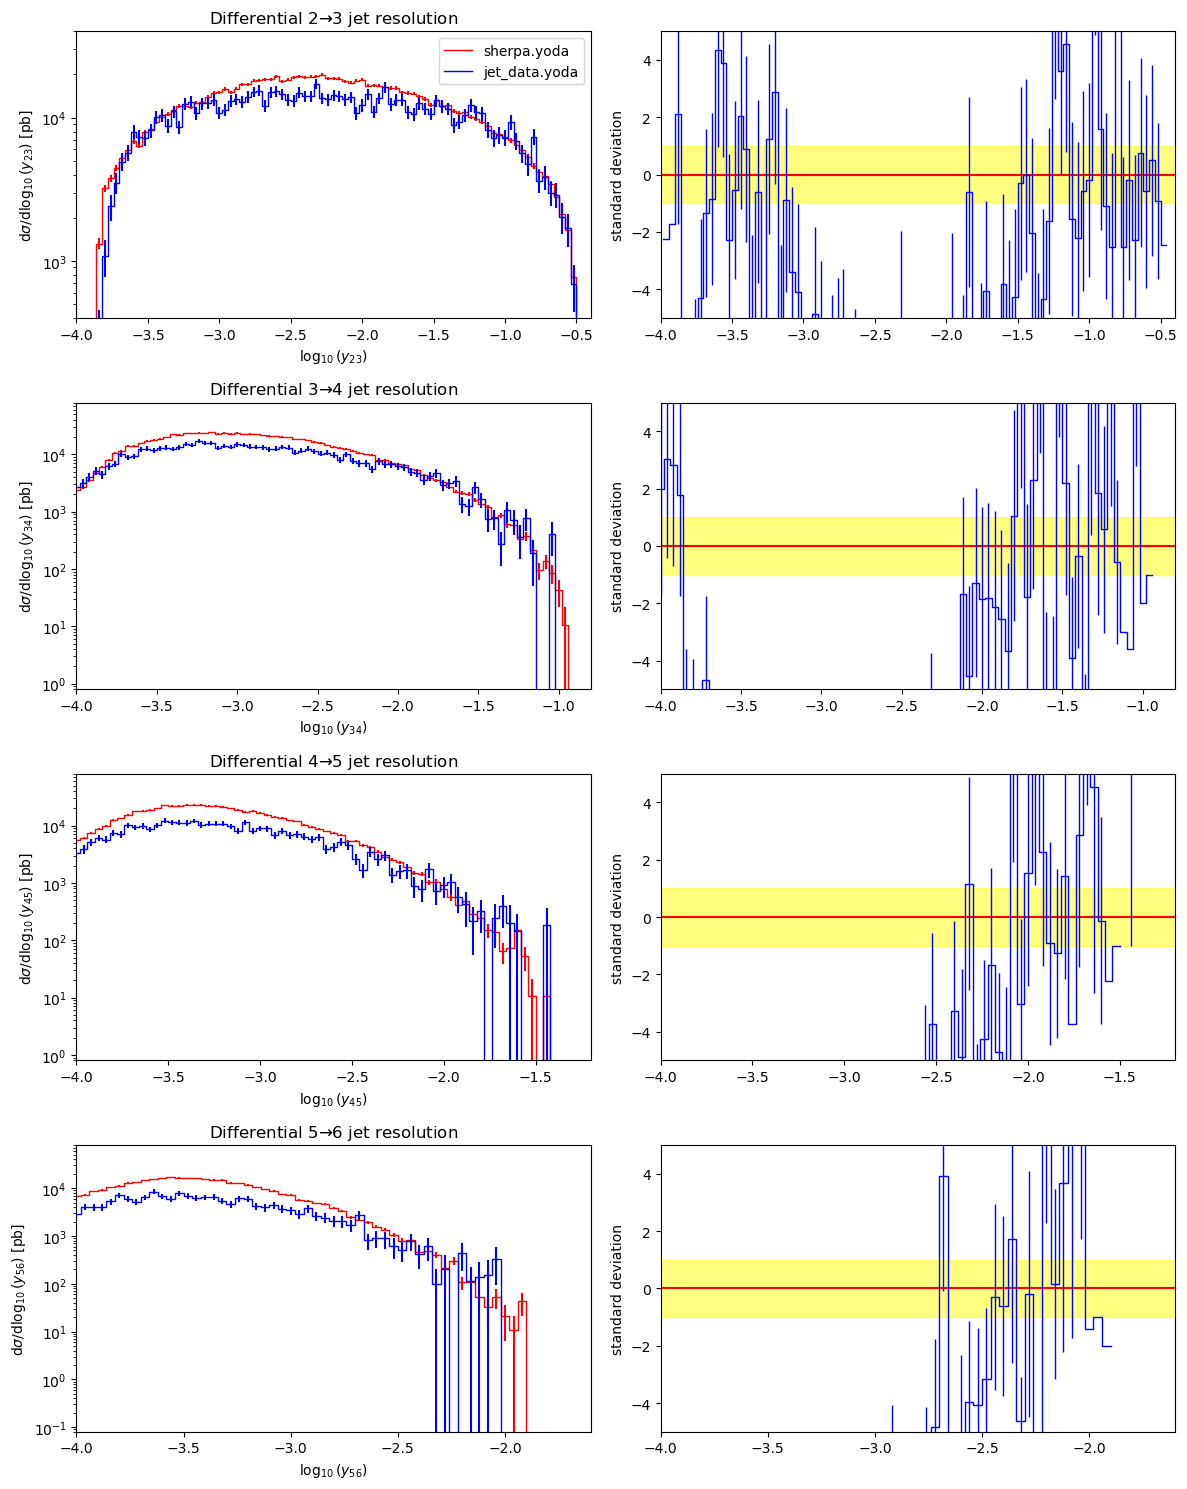

In [11]:
#1.2e
files = ['sherpa.yoda','jet_data.yoda']

plot_jet_histograms(files)
plt.savefig('jet_comparison.png',dpi=800)